In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
np.random.seed(7)

## Step 1 — Simulate raw log data
A typical request log may include:

- `timestamp` (when the request happened)
- `endpoint` (route like `/api/login`)
- `method` (GET/POST)
- `status` (HTTP status code)
- `latency_ms` (response time)
- `bytes` (response size)
- `user_id` (anonymized)
- `region` (client region)
- `cache_hit` (whether cached)

We will intentionally add **messy values** (missing fields, wrong types, outliers) to make the processing realistic.





In [20]:
#do step 1 here
import numpy as np
import pandas as pd

def simulate_logs(hours=24, house_count=10000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    n = hours * 60
    time_stamps = np.arange(1, n + 1)

    # Public car chargers (MJ per minute aggregated across city chargers)
    mu = 3.7876811131611228
    sigma = 0.8899150743790847
    public_car_chargers = np.random.lognormal(mean=mu, sigma=sigma, size=n)

    # Residential (MJ per minute aggregated across all houses)
    residential_house = np.random.randint(
        int((house_count * 5) / (24 * 60)),
        int((house_count * 40) / (24 * 60)) + 1,
        size=n
    )

    # --- Added columns (MJ per minute) ---

    # 1) Small commercial load (shops/offices): higher during daytime
    day_shape = (np.sin((np.arange(n) / 60 - 6) * np.pi / 12) + 1) / 2  # 0..1 peak ~noon
    small_commercial = np.random.lognormal(mean=2.2, sigma=0.5, size=n) * (0.3 + 1.2 * day_shape)

    # 2) Streetlights: mostly at night
    hour = (np.arange(n) / 60) % 24
    is_night = (hour >= 18) | (hour <= 6)
    streetlights = np.where(
        is_night,
        np.random.normal(loc=35, scale=6, size=n),   # MJ/min aggregated
        np.random.normal(loc=4, scale=1.5, size=n)
    )
    streetlights = np.clip(streetlights, 0, None)

    # 3) Water treatment / pumping: fairly steady with occasional spikes
    water_treatment = np.random.normal(loc=55, scale=4, size=n)
    spikes = np.random.rand(n) < 0.01
    water_treatment[spikes] += np.random.uniform(80, 200, size=spikes.sum())
    water_treatment = np.clip(water_treatment, 0, None)

    # 4) HVAC load (city-wide): peaks afternoon; mild at night
    hvac = np.random.lognormal(mean=2.8, sigma=0.35, size=n) * (0.4 + 1.6 * day_shape)

    # 5) Solar generation (as negative load): only daytime
    solar = np.where(
        (hour >= 7) & (hour <= 17),
        np.random.normal(loc=120, scale=25, size=n) * day_shape,
        0
    )
    solar = np.clip(solar, 0, None)
    solar_generation = -solar  # negative MJ/min offsets demand

    df = pd.DataFrame({
        "TimeStamp": time_stamps,
        "public_car_chargers": public_car_chargers,
        "residential_house": residential_house,
        "small_commercial": small_commercial,
        "streetlights": streetlights,
        "water_treatment": water_treatment,
        "hvac_load": hvac,
        "solar_generation": solar_generation,
    })

    return df
df = simulate_logs()


# data dirtying 


def dirty_data(df, seed=None):
    if seed is not None:
        np.random.seed(seed)

    df = df.copy()
    cols = df.columns.drop("TimeStamp")

    # 1) Inject missing values (1%)
    for col in cols:
        mask = np.random.rand(len(df)) < 0.01
        df.loc[mask, col] = np.nan

    # 2) Inject outliers (0.5%)
    for col in cols:
        mask = np.random.rand(len(df)) < 0.005
        df.loc[mask, col] *= np.random.uniform(5, 10)

    return df


# Replace df with its dirty version
df = dirty_data(df, seed=42)

print(df)


      TimeStamp  public_car_chargers  residential_house  small_commercial  \
0             1           198.761462         232.000000          1.814570   
1             2            29.166956          35.000000          1.830007   
2             3            45.462521         272.000000          3.942090   
3             4            63.455317          83.000000          1.073050   
4             5            21.880736         245.000000          1.121409   
...         ...                  ...                ...               ...   
1435       1436           207.754699         115.000000          2.027177   
1436       1437           121.426653          48.000000          2.326657   
1437       1438            59.087552         164.000000          3.705105   
1438       1439            12.541238         127.000000          3.176245   
1439       1440            20.830492         416.190051          3.557830   

      streetlights  water_treatment  hvac_load  solar_generation  
0       

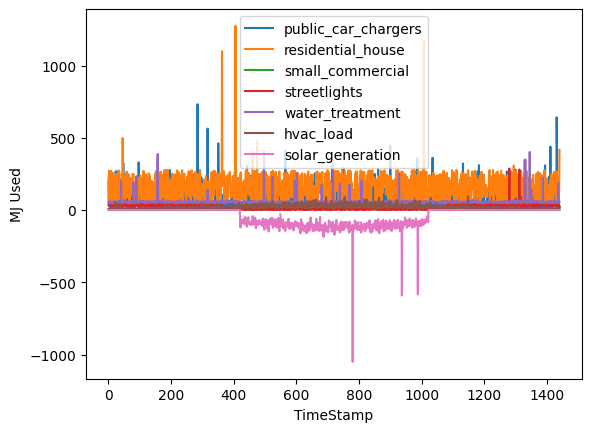

In [21]:
import matplotlib.pyplot as plt

x = df["TimeStamp"]

for col in df.columns:
    if col != "TimeStamp":
        plt.plot(x, df[col], label=col)

plt.xlabel("TimeStamp")
plt.ylabel("MJ Used")
plt.legend()
plt.show()

## Step 2 — Basic DataFrame understanding
Key first steps:

1) `info()` (dtypes + missing values)
2) `describe()` for numeric columns
3) check for duplicates and missingness

raw.info()
raw.describe(include='all').T
# Missing values per column
raw.isna().sum().sort_values(ascending=False)


In [22]:
# -------------------------------
# Step 2 — Basic DataFrame understanding
# -------------------------------

print("\n=== DataFrame Structure (dtypes & non-null counts) ===")
df.info()

print("\n=== Descriptive Statistics (all columns) ===")
print(df.describe(include="all").T)

print("\n=== Missing Values: Count per Column ===")
missing_by_column = df.isna().sum().sort_values(ascending=False)
print(missing_by_column)

print("\n=== Missing Values: Percentage per Column ===")
missing_pct = (df.isna().mean() * 100).round(2)
print(missing_pct.sort_values(ascending=False))



=== DataFrame Structure (dtypes & non-null counts) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TimeStamp            1440 non-null   int64  
 1   public_car_chargers  1432 non-null   float64
 2   residential_house    1424 non-null   float64
 3   small_commercial     1427 non-null   float64
 4   streetlights         1428 non-null   float64
 5   water_treatment      1425 non-null   float64
 6   hvac_load            1424 non-null   float64
 7   solar_generation     1421 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 90.1 KB

=== Descriptive Statistics (all columns) ===
                      count        mean         std          min         25%  \
TimeStamp            1440.0  720.500000  415.836506     1.000000  360.750000   
public_car_chargers  1432.0   63.718049   65.271120     2.436467   24.046576   
r

## Step 3 — Cleaning and type fixes
Common issues we will fix:

- `timestamp` should be datetime
- `bytes` contains strings like `'12,345'`
- negative latency values
- missing endpoints

We'll produce a clean DataFrame called `df`.


In [ ]:
# -------------------------------
# Step 3 — Cleaning and type fixes
# -------------------------------

df = df.copy()

# 1) Ensure numeric columns are numeric (dirtying can introduce NaN and weird types)
numeric_cols = df.columns.drop("TimeStamp")
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# 2) Sanity constraints (domain rules)
# - These loads should never be negative
non_negative_cols = [
    "public_car_chargers",
    "residential_house",
    "small_commercial",
    "streetlights",
    "water_treatment",
    "hvac_load",
]
for c in non_negative_cols:
    if c in df.columns:
        df[c] = df[c].clip(lower=0)

# - Solar generation is negative or zero by design (it's an offset)
#   But if anything made it positive, force it back to <= 0
if "solar_generation" in df.columns:
    df["solar_generation"] = df["solar_generation"].clip(upper=0)

# 3) Handle missing values (simple baseline strategy)
# - For continuous-ish signals, interpolate over time then fill edges
interp_cols = [
    "public_car_chargers",
    "small_commercial",
    "streetlights",
    "water_treatment",
    "hvac_load",
    "solar_generation",
]
for c in interp_cols:
    if c in df.columns:
        df[c] = df[c].interpolate(method="linear", limit_direction="both")

# - For residential_house (integer-ish), fill and cast back to int
if "residential_house" in df.columns:
    df["residential_house"] = df["residential_house"].interpolate(method="linear", limit_direction="both")
    df["residential_house"] = df["residential_house"].round().astype("Int64")  # nullable int

# 4) Create a real datetime column from the minute index
# If you don't want this, delete this block.
start_time = pd.Timestamp("2026-02-05 00:00:00")
df["timestamp"] = start_time + pd.to_timedelta(df["TimeStamp"] - 1, unit="min")


## Step 4 — Handling outliers (realistic)
Response time often has a long tail. We typically **cap** extreme values or remove them depending on context.

Here we will cap at the 99th percentile (winsorize) so plots are readable, but we keep the rows.

p99 = df["latency_ms"].quantile(0.99)
df["latency_ms_capped"] = df["latency_ms"].clip(upper=p99)

p99



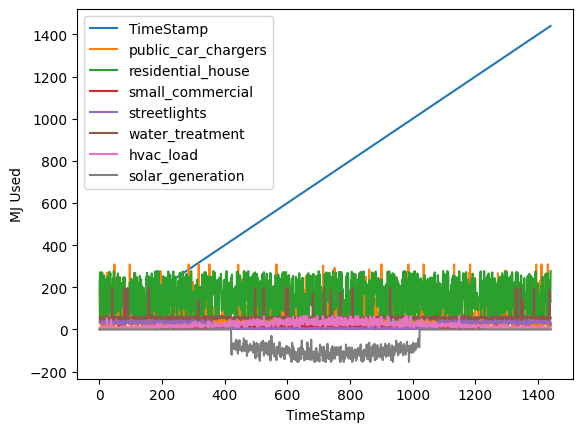

In [ ]:
#do step 4 here
numeric_cols = df.columns.drop("TimeStamp")

p99 = df[numeric_cols].quantile(0.99)

for col in numeric_cols:
    df[col] = df[col].clip(upper=p99[col])

p01 = df[numeric_cols].quantile(0.01)

for col in numeric_cols:
    df[col] = df[col].clip(lower=p01[col], upper=p99[col])

x = df["TimeStamp"]

for col in df.columns:
    if col != "timestamp" and col != "TimeStamp":
        plt.plot(x, df[col], label=col)

plt.xlabel("TimeStamp")
plt.ylabel("MJ Used")
plt.legend()
plt.show()


## Step 5 — Feature engineering
Feature engineering = creating useful columns for analysis.

We'll create:

- `minute` (timestamp floored to minute) for time aggregation
- `hour`
- `endpoint_group` (collapse `/api/items/123` into `/api/items/{id}`)
- `is_error`
- `latency_bucket` (fast/ok/slow)


In [25]:
#do step 5 here
# 30-minute rolling window
w = 30

# 1) Total city demand (smoothed)
df["total_demand_mj_min_30m"] = (
    df["public_car_chargers"]
    + df["residential_house"]
    + df["small_commercial"]
    + df["streetlights"]
    + df["water_treatment"]
    + df["hvac_load"]
    + df["solar_generation"]
).rolling(window=w, min_periods=1).mean()

# 2) Demand without EV (smoothed)
df["demand_no_ev_mj_min_30m"] = (
    df["total_demand_mj_min_30m"] - df["public_car_chargers"].rolling(w, min_periods=1).mean()
)

# 3) Residential % of total (smoothed)
res_30 = df["residential_house"].rolling(w, min_periods=1).mean()
df["residential_pct_of_total_30m"] = (res_30 / df["total_demand_mj_min_30m"]) * 100

# 4) Peak demand flag (based on smoothed total)
peak_threshold_30m = df["total_demand_mj_min_30m"].quantile(0.95)
df["is_peak_demand_30m"] = df["total_demand_mj_min_30m"] >= peak_threshold_30m


## Step 6 — Aggregations (the core of processing)
### A) Traffic over time
Requests per minute + error rate per minute.

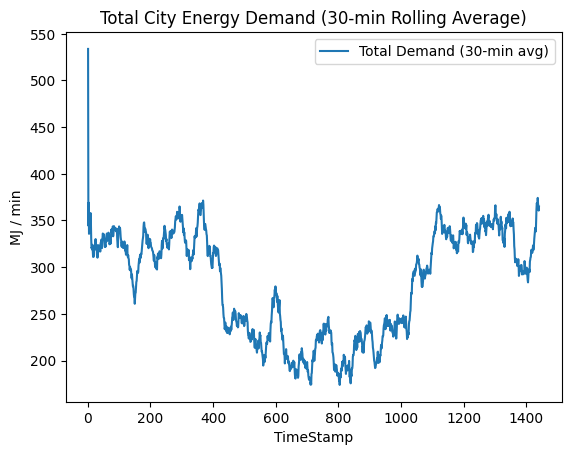

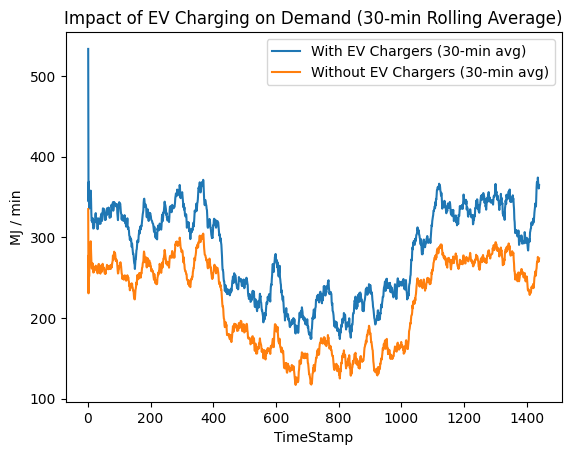

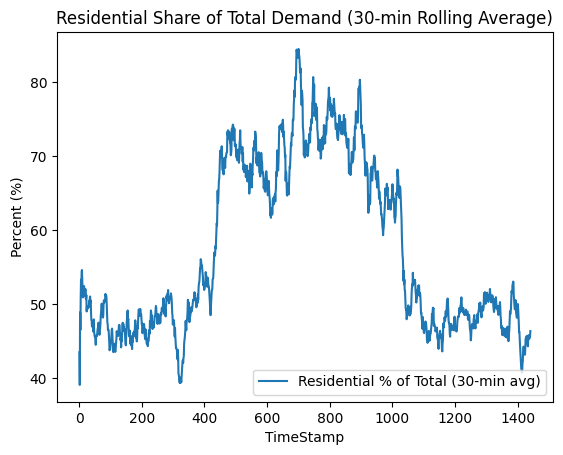

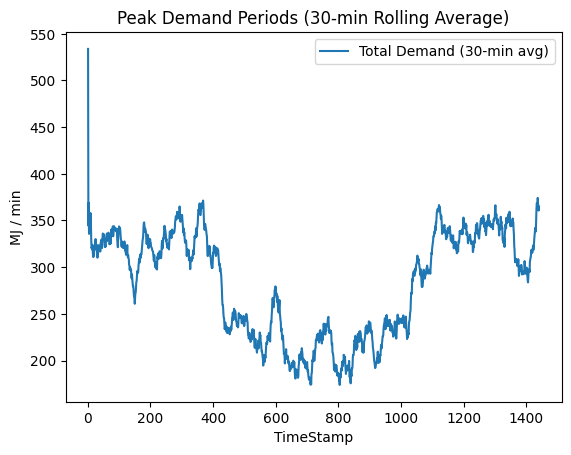

In [26]:
#do step 6 here
import matplotlib.pyplot as plt

x = df["TimeStamp"]

# 1) Smoothed total city demand
plt.figure()
plt.plot(x, df["total_demand_mj_min_30m"], label="Total Demand (30-min avg)")
plt.xlabel("TimeStamp")
plt.ylabel("MJ / min")
plt.title("Total City Energy Demand (30-min Rolling Average)")
plt.legend()
plt.show()

# 2) Smoothed with EV vs without EV
plt.figure()
plt.plot(x, df["total_demand_mj_min_30m"], label="With EV Chargers (30-min avg)")
plt.plot(x, df["demand_no_ev_mj_min_30m"], label="Without EV Chargers (30-min avg)")
plt.xlabel("TimeStamp")
plt.ylabel("MJ / min")
plt.title("Impact of EV Charging on Demand (30-min Rolling Average)")
plt.legend()
plt.show()

# 3) Smoothed residential % of total
plt.figure()
plt.plot(x, df["residential_pct_of_total_30m"], label="Residential % of Total (30-min avg)")
plt.xlabel("TimeStamp")
plt.ylabel("Percent (%)")
plt.title("Residential Share of Total Demand (30-min Rolling Average)")
plt.legend()
plt.show()

# 4) Smoothed peak demand highlighted
plt.figure()
plt.plot(x, df["total_demand_mj_min_30m"], label="Total Demand (30-min avg)")
plt.xlabel("TimeStamp")
plt.ylabel("MJ / min")
plt.title("Peak Demand Periods (30-min Rolling Average)")
plt.legend()
plt.show()


## Summary of what we did
- simulated messy, realistic energy usage data
- loaded into a DataFrame
- inspected data types and missingness
- cleaned and fixed types and missing values
- capped outliers for readability
- engineered features for analysis
- aggregated and visualized trends